In [2]:
import numpy as np
import sys
from scipy.linalg import expm
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from IPython.display import display
from single_hopping import *
from double_hopping import *
from qiskit import transpile
import matplotlib.pyplot as plt


In [70]:
def create_ladder_cnot(qc, i, j, N):
    for a in range(i,j):
        qc.cx(N-a-1, N - a - 2)
    return None

def create_inverse_ladder_cnot(qc, i, j, N):
    for a in range(j,i,-1):
        qc.cx(N-a, N - a - 1)
    return None


def construct_inter_controlled_single_hopping_qubit_matrix(i,j,k,t,N):
    y = np.array([[0, -1j], [1j, 0]])
    x = np.array([[0, 1], [1, 0]])
    z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    A = 1
    B = 1
    C = 1
    D = 1
    for a in range(N):
        if a < i:
            A = np.kron(A,I)
            B = np.kron(B,I)
            C = np.kron(C,I)
            D = np.kron(D,I)
        elif a == i:
            A = np.kron(A,y)
            B = np.kron(B,y)
            C = np.kron(C,x)
            D = np.kron(D,x)
        elif a < j:
            A = np.kron(A,z)
            B = np.kron(B,z)
            C = np.kron(C,z)
            D = np.kron(D,z)
        elif a == j:
            A = np.kron(A,z)
            B = np.kron(B,I)
            C = np.kron(C,z)
            D = np.kron(D,I)
        elif a < k:
            A = np.kron(A,z)
            B = np.kron(B,z)
            C = np.kron(C,z)
            D = np.kron(D,z)
        elif a == k:
            A = np.kron(A,x)
            B = np.kron(B,x)
            C = np.kron(C,y)
            D = np.kron(D,y)
        else:
            A = np.kron(A,I)
            B = np.kron(B,I)
            C = np.kron(C,I)
            D = np.kron(D,I)
    return t*(-1j*A+1j*B+1j*C-1j*D)/4

def construct_outer_controlled_single_hopping_qubit_matrix(i,j,k,t,N):
    y = np.array([[0, -1j], [1j, 0]])
    x = np.array([[0, 1], [1, 0]])
    z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    A = 1
    B = 1
    C = 1
    D = 1
    for a in range(N):
        if a < i:
            A = np.kron(A,I)
            B = np.kron(B,I)
            C = np.kron(C,I)
            D = np.kron(D,I)
        elif a == i:
            A = np.kron(A,y)
            B = np.kron(B,y)
            C = np.kron(C,x)
            D = np.kron(D,x)
        elif a < k:
            A = np.kron(A,z)
            B = np.kron(B,z)
            C = np.kron(C,z)
            D = np.kron(D,z)
        elif a == k:
            A = np.kron(A,x)
            B = np.kron(B,x)
            C = np.kron(C,y)
            D = np.kron(D,y)
        elif a < j:
            A = np.kron(A,I)
            B = np.kron(B,I)
            C = np.kron(C,I)
            D = np.kron(D,I)
        elif a == j:
            A = np.kron(A,z)
            B = np.kron(B,I)
            C = np.kron(C,z)
            D = np.kron(D,I)
        else:
            A = np.kron(A,I)
            B = np.kron(B,I)
            C = np.kron(C,I)
            D = np.kron(D,I)
    return t*(-1j*A+1j*B+1j*C-1j*D)/4

def construct_controlled_single_hopping_qubit_matrix(i,j,k,N,t):
    print(N)
    if j > k:
        return construct_outer_controlled_single_hopping_qubit_matrix(i,j,k,t,N)
    else:
        return construct_inter_controlled_single_hopping_qubit_matrix(i,j,k,t,N)

In [4]:
N = 7
i = 2
j = 6
k = 4
t = 10
H = construct_controlled_single_hopping_qubit_matrix(i, j, k, t, N)
ops = FermionicOp({"+_" + str(i)+" +_"+str(j)+ " -_" + str(j)+" -_"+str(k) : t,\
                    "+_" + str(k)+" +_"+str(j)+ " -_" + str(j)+" -_"+str(i):-t}, num_spin_orbitals=N)
mapper = JordanWignerMapper()
jw_op = mapper.map(ops)
jw_op = qi.Operator(jw_op).to_matrix()
jw_op = np.array(jw_op)

eigH = np.linalg.eig(H)[0]

eigJW = np.linalg.eig(jw_op)[0]
eigH = np.sort(1j*eigH)
eigJW = np.sort(1j*eigJW)
print(f"i = {i}, j = {j}, k = {k}, N = {N}")
print(f"The norm of the eigenvalue of qubit matrix is {np.linalg.norm(eigH)}")
print(f"The norm of the eigenvalue of the JW transformation from Qiskit is {np.linalg.norm(eigJW)}")
print(f"The difference between two eigenvalue vector is {np.sum(abs(eigH - eigJW))}")

i = 2, j = 6, k = 4, N = 7
The norm of the eigenvalue of qubit matrix is 56.56854249492381
The norm of the eigenvalue of the JW transformation from Qiskit is 56.56854249492381
The difference between two eigenvalue vector is 0.0


In [93]:
def construct_inter_controlled_single_hopping_circuit(i,j,k,N,t):
    qc = QuantumCircuit(N)
    
    # Component 1
    qc.sdg(N-i-1)
    qc.h(N-i-1)
    qc.h(N-k-1)
    create_ladder_cnot(qc, i, k, N)
    qc.rz(t/2, N-k-1)
    create_inverse_ladder_cnot(qc, i, k, N)
    qc.h(N-i-1)
    qc.s(N-i-1)
    qc.h(N-k-1)

    #Component 2
    qc.sdg(N-i-1)
    qc.h(N-i-1)
    qc.h(N-k-1)
    create_ladder_cnot(qc, i, j-1, N)
    qc.cx(N-j, N-j-2)
    create_ladder_cnot(qc, j+1, k, N)
    qc.rz(-t/2, N-k-1)

    create_inverse_ladder_cnot(qc, j+1, k, N)
    qc.cx(N-j, N-j-2)
    create_inverse_ladder_cnot(qc, i, j-1, N)
    
    qc.h(N-i-1)
    qc.s(N-i-1)
    qc.h(N-k-1)

    # Component 3
    qc.sdg(N-k-1)
    qc.h(N-k-1)
    qc.h(N-i-1)
    create_ladder_cnot(qc, i, k, N)
    qc.rz(-t/2, N-k-1)
    create_inverse_ladder_cnot(qc, i, k, N)
    qc.h(N-k-1)
    qc.s(N-k-1)
    qc.h(N-i-1)

    # Component 4
    qc.sdg(N-i-1)
    qc.h(N-i-1)
    qc.h(N-k-1)
    create_ladder_cnot(qc, i, j-1, N)
    qc.cx(N-j, N-j-2)
    create_ladder_cnot(qc, j+1, k, N)
    
    qc.rz(t/2, N-k-1)

    create_inverse_ladder_cnot(qc, j+1, k, N)
    qc.cx(N-j, N-j-2)
    create_inverse_ladder_cnot(qc, i, j-1, N)
    
    
    qc.h(N-i-1)
    qc.s(N-i-1)
    qc.h(N-k-1)
    return qc
    

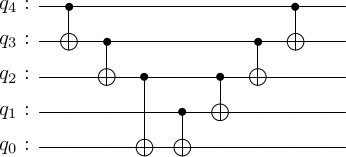

In [54]:
N = 5
i = 0
j = 2
k = 4
qc = QuantumCircuit(N)
create_ladder_cnot(qc,i, j, N)
qc.cx(N-j-1, N-j-3)
create_ladder_cnot(qc, j+2, k, N)
create_inverse_ladder_cnot(qc, i, k ,N)
display(qc.draw("latex", reverse_bits=True))

In [ ]:
N = 3
i = 0
j = 1
k = 2
t = 0.1
qc = construct_inter_controlled_single_hopping_circuit(i,j,k,N,t)
M = qi.Operator(qc).to_matrix()
M = np.array(M)
H = construct_controlled_single_hopping_qubit_matrix(i,j,k,N,t)
H = expm(t*H)
print(np.sum(abs(H-M)))


3
0.1848159696678549


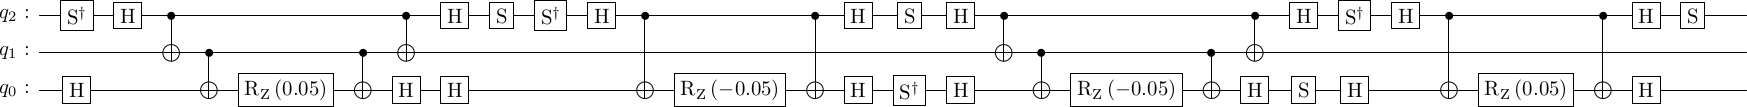

In [102]:
display(qc.draw("latex", reverse_bits=True))